In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
import librosa
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
import time

In [2]:
PATH = '/home/ferreiraa/Documents/Mestrado/trabalho/redeNeural/agender_distribution/'

In [3]:
def Feat_extract(files):
    file_name = os.path.join(os.path.abspath(PATH+str(files.file)))
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    # Generate Mel-frequency cepstral coefficients (MFCCs) and Delta-MFCCs from a time series
    MFCC_ = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    mfccs = np.mean(MFCC_.T,axis=0)
    Delta_Mfcc = np.mean(librosa.feature.delta(MFCC_).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)# Computes melspectrogram
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),sr=sample_rate).T,axis=0) #Compute 6 features based on Tones
    contrast = np.mean(librosa.feature.spectral_contrast(S=np.abs(librosa.stft(X)), sr=sample_rate).T,axis=0) # Computes spectral contrast
    ZCR = np.mean(librosa.feature.zero_crossing_rate(y=X).T,axis=0) # Zero-Crossing rate - 1 Value
    RMS = np.mean(librosa.feature.rms(y=X).T,axis=0) # RMS - 1 Value
    np.savez(file_name, mfccs=mfccs, Delta_Mfcc=Delta_Mfcc, contrast=contrast, mel=mel, tonnetz=tonnetz, ZCR=ZCR, RMS=RMS)
    return mfccs, Delta_Mfcc, contrast, mel, tonnetz, ZCR, RMS

In [4]:
Batch = 128
Epoch = 100

#Read files and split result from file
Train_file = pd.read_csv("Csv/train.csv")
Test_file = pd.read_csv("Csv/test.csv")
#Val_file = pd.read_csv("Csv/Valid_2.csv")
Arq_train = Train_file['file']
Arq_test = Test_file['file']
#Arq_val = Val_file['file']
Res_train = Train_file['class']
Res_test = Test_file['class']
#Res_val = Val_file['class']

V_train_x = []
for i in Arq_train:
    if i !='file':
        V_train_x.append(i)

V_test_x = []
for i in Arq_test:
    if i !='file':
        V_test_x.append(i)

'''V_val_x = []
for i in Arq_val:
    if i !='file':
        V_val_x.append(i)'''

train_df = pd.DataFrame(V_train_x)
test_df = pd.DataFrame(V_test_x)
#val_df = pd.DataFrame(V_val_x)

train_df = train_df.rename(columns={0:'file'})
test_df = test_df.rename(columns={0:'file'})
#val_df = val_df.rename(columns={0:'file'})

In [ ]:
#train_features = train_df.apply(Feat_extract, axis=1)
#ini_feat = time.time()
#test_features = test_df.apply(Feat_extract, axis=1)
#fim_feat = time.time() - ini_feat
#val_features = val_df.apply(Feat_extract, axis=1)

In [5]:
features_train = []
for i in range(0, len(train_df)):
    a = np.load(PATH + train_df['file'][i] + '.npz')
    features_train.append(np.concatenate((
        a['mfccs'],
        a['Delta_Mfcc'],
        a['contrast'],
        a['mel'],
        a['tonnetz'],
        a['ZCR'],
        a['RMS']), axis=0))
    
features_test = []
for i in range(0, len(test_df)):
    b = np.load(PATH + test_df['file'][i] + '.npz')
    features_test.append(np.concatenate((
        b['mfccs'],
        b['Delta_Mfcc'],
        b['contrast'],
        b['mel'],
        b['tonnetz'],
        b['ZCR'],
        b['RMS']), axis=0))
    
"""features_val = []
for i in range(0, len(val_df)):
    c = np.load(PATH + val_df['file'][i] + '.npz')
    features_val.append(np.concatenate((
        c['mfccs'],
        c['Delta_Mfcc'],
        c['contrast'],
        c['mel'],
        c['tonnetz'],
        c['ZCR'],
        c['RMS']), axis=0))"""

"features_val = []\nfor i in range(0, len(val_df)):\n    c = np.load(PATH + val_df['file'][i] + '.npz')\n    features_val.append(np.concatenate((\n        c['mfccs'],\n        c['Delta_Mfcc'],\n        c['contrast'],\n        c['mel'],\n        c['tonnetz'],\n        c['ZCR'],\n        c['RMS']), axis=0))"

In [6]:
X_test = np.array(features_test)
X_train = np.array(features_train)
Y_train = np.array(Res_train)
#X_val = np.array(features_val)
#Y_val = np.array(Res_val)

lb = LabelEncoder()
Y_train = to_categorical(lb.fit_transform(Y_train))
#Y_val = to_categorical(lb.fit_transform(Y_val))

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
#X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

input = 223

In [7]:
InpSp = input
Y_test = Res_test

In [8]:
HU = int(InpSp * 3) # Hiddent units (First Hidden Layer)
model = Sequential()
model.add(Dense(HU, input_shape=(InpSp,), activation = 'relu'))
model.add(Dense(InpSp*2, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(InpSp, activation = 'relu'))
model.add(Dropout(0.15))
model.add(Dense(6, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [10]:
ini_train = time.time()
#history = model.fit(X_train, Y_train, batch_size=Batch, epochs=Epoch, validation_data=(X_val, Y_val))#,callbacks=[early_stop])
history = model.fit(X_train, Y_train, batch_size=Batch, epochs=Epoch, validation_split=0.1)
#model.save("model_"+str(Epoch)+'_'+str(Batch))
fim_train = time.time() - ini_train

Epoch 1/100
198/198 [==============================] - 2s 9ms/step - loss: 0.9871 - accuracy: 0.6103 - val_loss: 1.4319 - val_accuracy: 0.4509
Epoch 2/100
198/198 [==============================] - 1s 8ms/step - loss: 0.8192 - accuracy: 0.6863 - val_loss: 2.3589 - val_accuracy: 0.2784
Epoch 3/100
198/198 [==============================] - 2s 8ms/step - loss: 0.6855 - accuracy: 0.7377 - val_loss: 2.7246 - val_accuracy: 0.2977
Epoch 4/100
198/198 [==============================] - 1s 8ms/step - loss: 0.5861 - accuracy: 0.7783 - val_loss: 2.5362 - val_accuracy: 0.3834
Epoch 5/100
198/198 [==============================] - 1s 8ms/step - loss: 0.4938 - accuracy: 0.8158 - val_loss: 2.7939 - val_accuracy: 0.3659
Epoch 6/100
198/198 [==============================] - 2s 8ms/step - loss: 0.4263 - accuracy: 0.8422 - val_loss: 2.9216 - val_accuracy: 0.3389
Epoch 7/100
198/198 [==============================] - 2s 8ms/step - loss: 0.3614 - accuracy: 0.8676 - val_loss: 2.8073 - val_accuracy: 0.3919

In [11]:
file = open("FULL_DNNTestes.txt",'a+')
file.write("Teste_ com "+str(Epoch)+" epocas e "+str(Batch)+" de batch: \n")
#file.write("Tempo de Retirada de caracteristicas: "+str((1.0*fim_feat)/len(Y_test))+'\n')
#file.write("Tempo de Retirada de caracteristicas (adj): "+str(fim_feat)+'\n')
file.write("Tempo de Treino: "+str(fim_train)+'\n')

36

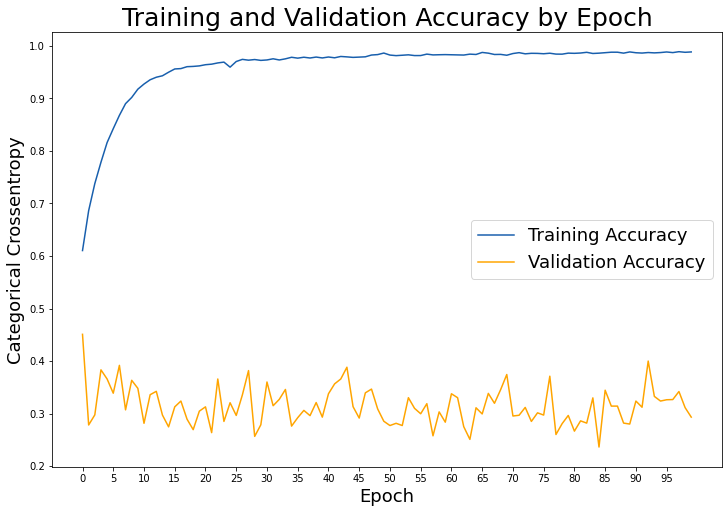

In [12]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']# Set figure size.
plt.figure(figsize=(12, 8))# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,int(Epoch),int(Epoch/20)), range(0,int(Epoch),int(Epoch/20)))
plt.legend(fontsize = 18);
plt.show()

In [13]:
ini_test = time.time()
predictions = np.argmax(model.predict(X_test), axis=-1)
predictions = lb.inverse_transform(predictions)
test_predict = predictions
fim_test = time.time() - ini_test

In [14]:
file.write("Tempo de Teste: "+str((1.0*fim_test)/len(Y_test))+'\n')
file.write("Tempo de Teste (adj): "+str(fim_test)+'\n')

41

In [15]:
correct_predict = 0.0
for i in range(0,len(Y_test)):
    if str(test_predict[i]) != 'NaN' and int(test_predict[i]) == int(Y_test[i]):
        correct_predict += 1
print("A porcentagem de acerto é de : "+str((correct_predict*100)/len(Y_test))+"%")

A porcentagem de acerto é de : 34.717937417364475%


In [16]:
file.write("Porcentagem de acerto: "+str((correct_predict*100)/len(Y_test))+"%\n")
file.write('##########\n')
file.close()

In [ ]:
#file = open("FULL_DNN_Confusion_matrix.txt",'a+')
#file.write("Usando_: Batch = "+str(Batch)+" | Epochs = "+str(Epoch)+'\n')
#for i in ConfMat:
#    file.write(str(i)+'\n')
#file.close()